In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import superscreen as sc
from superscreen.geometry import box

import squids
from squids.ibm.alignment import find_minimum_standoff
import susceptometry

In [2]:
squid = squids.ibm.medium.make_squid()

In [3]:
squid.make_mesh(max_edge_length=0.1, smooth=10)

<IPython.core.display.Javascript object>


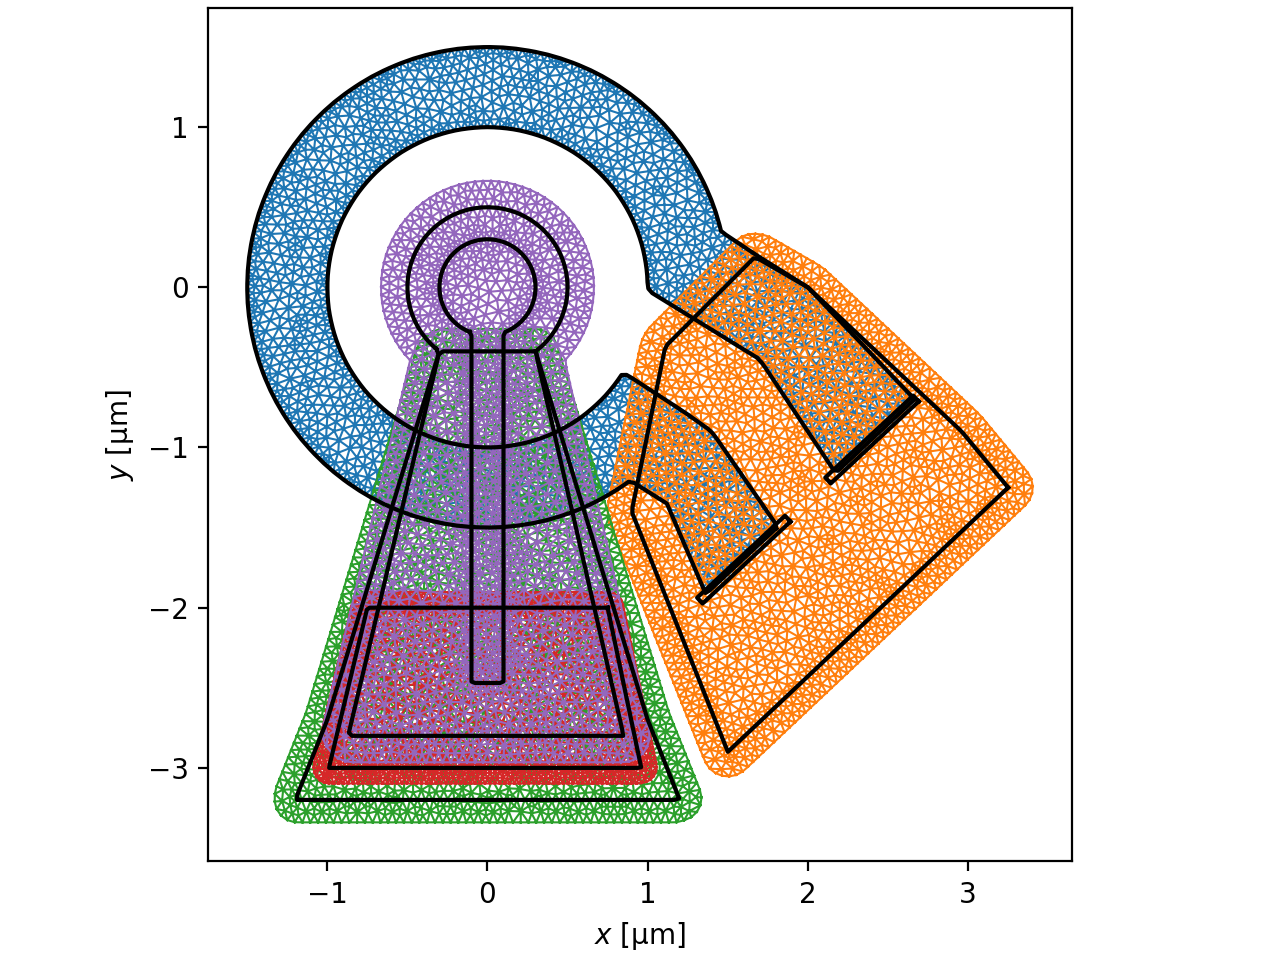

In [4]:
fig, ax = squid.plot_mesh()
_ = squid.plot_polygons(ax=ax, color="k")

In [5]:
fc_solution, bare_mutual = susceptometry.get_mutual(squid, iterations=5)

Solver iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.82it/s]


In [6]:
bare_mutual

157.59319753684488 <Unit('magnetic_flux_quantum / ampere')>

In [7]:
eval_mesh = sc.Polygon(points=box(10, 10)).make_mesh(max_edge_length=0.2)

<IPython.core.display.Javascript object>


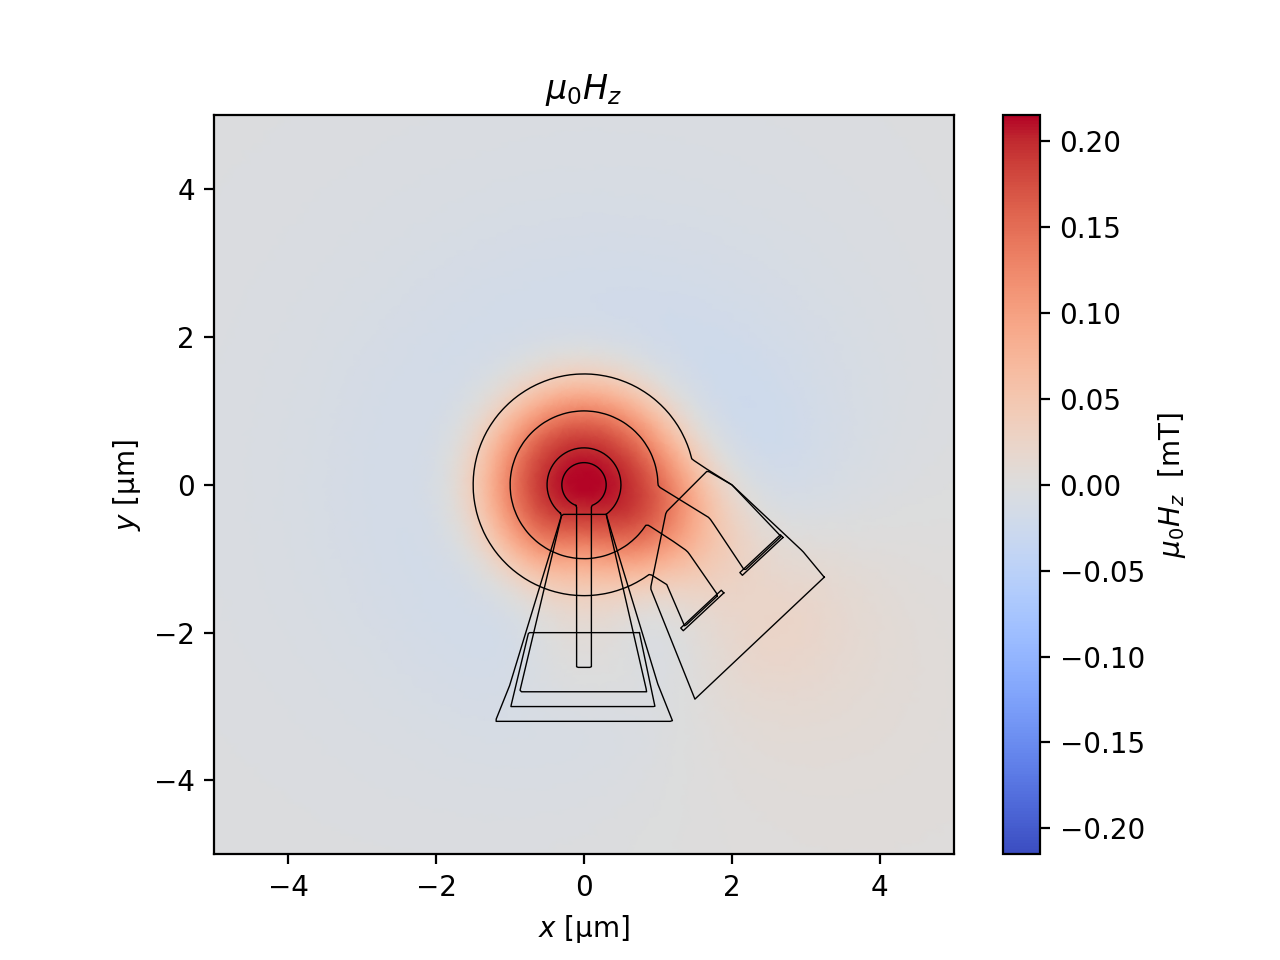

In [8]:
fig, ax = fc_solution.plot_field_at_positions(eval_mesh, zs=-0.5, symmetric_color_scale=True, cmap="coolwarm")
_ = squid.plot_polygons(ax=ax, color="k", lw=0.5)

In [9]:
side_view = squids.ibm.medium.make_squid_side_view(squid_height=0.1, squid_angle=4)

<IPython.core.display.Javascript object>


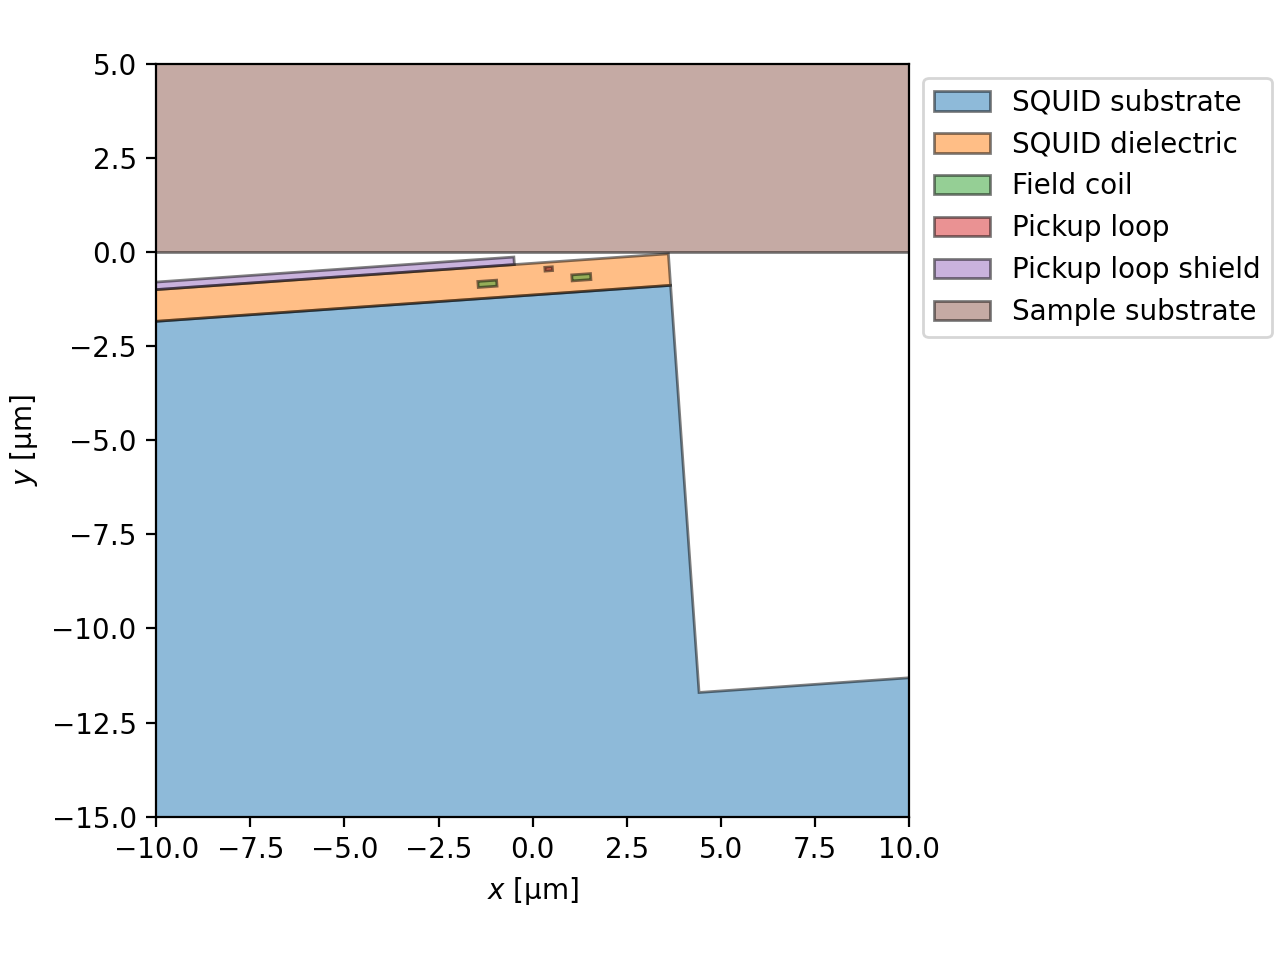

(-15.0, 5.0)

In [10]:
fig, ax = side_view.draw(legend=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-15, 5)

In [11]:
angles = np.linspace(0, 6, 101)
standoffs = np.linspace(-1, 3, 601)
angles, min_standoffs = find_minimum_standoff("medium", angles=angles)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:06<00:00, 14.95it/s]


<IPython.core.display.Javascript object>


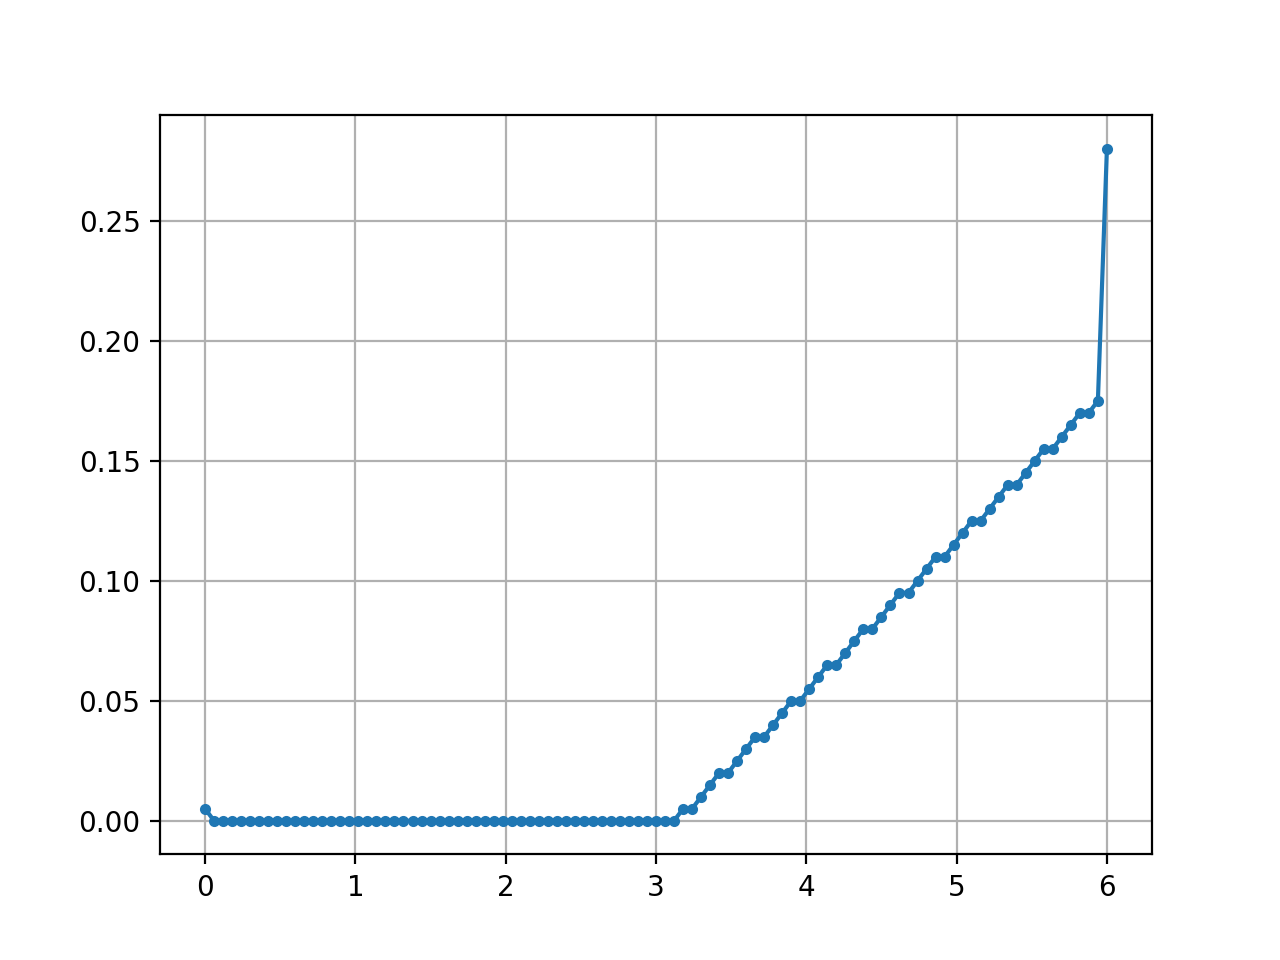

In [12]:
fig, ax = plt.subplots()
ax.plot(angles, min_standoffs, ".-")
ax.grid(True)

<IPython.core.display.Javascript object>


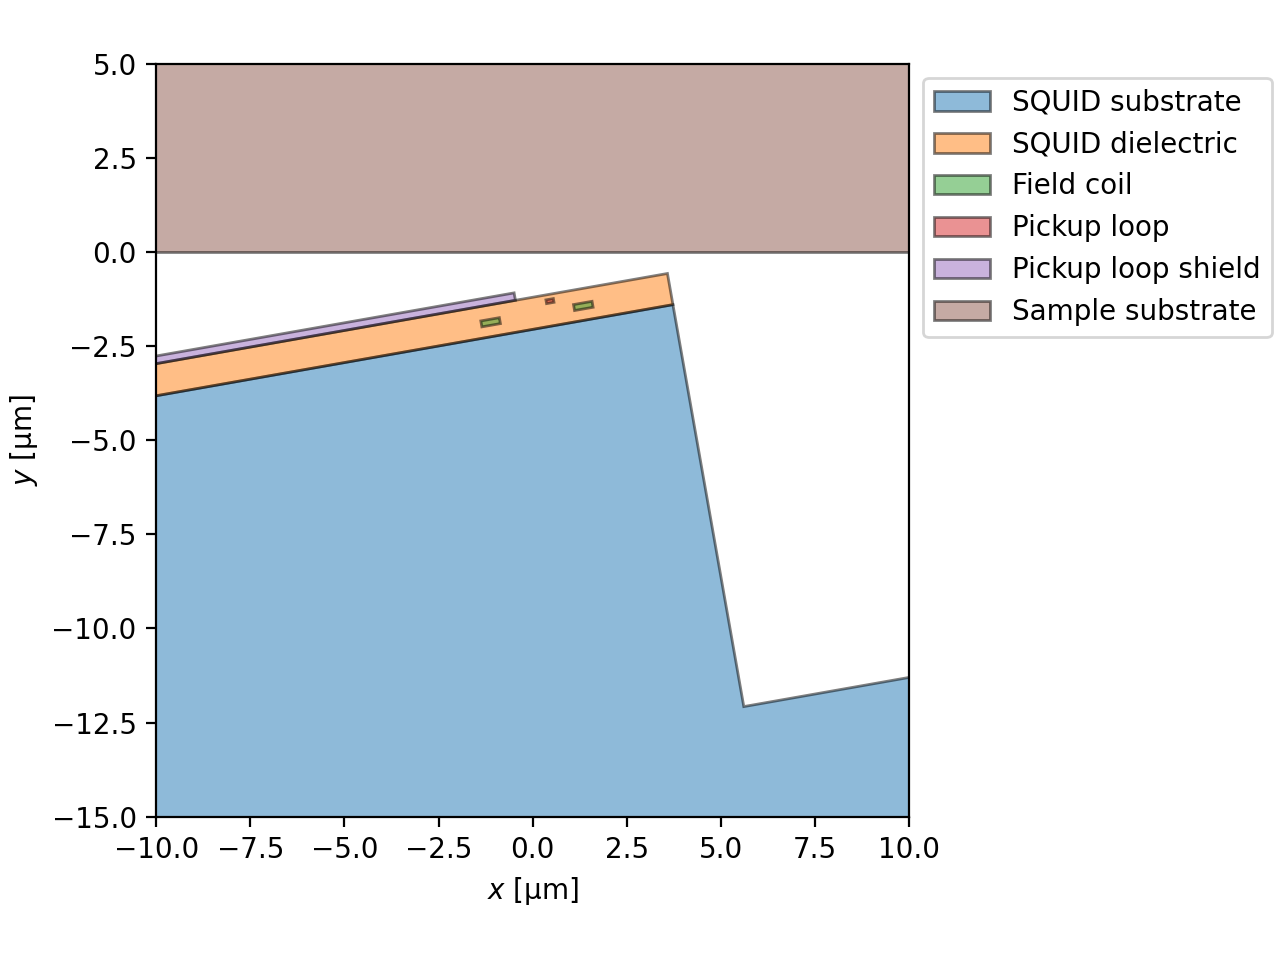

(-15.0, 5.0)

In [13]:
side_view = squids.ibm.medium.make_squid_side_view(squid_height=1, squid_angle=10)
fig, ax = side_view.draw(legend=True)
ax.set_xlim(-10, 10)
ax.set_ylim(-15, 5)

In [14]:
sample_Lambda = 1.0
sample = susceptometry.make_sample(width=20, height=20, Lambda=sample_Lambda, z0=0, max_edge_length=0.4)
sample_mesh = sample.meshes["sample"]
sample_xs = sample_mesh.sites[:, 0]
sample_ys = sample_mesh.sites[:, 1]
sample_zs = sample.layers["sample"].z0 * np.ones_like(sample_xs)
sample_tris = sample_mesh.elements

<IPython.core.display.Javascript object>


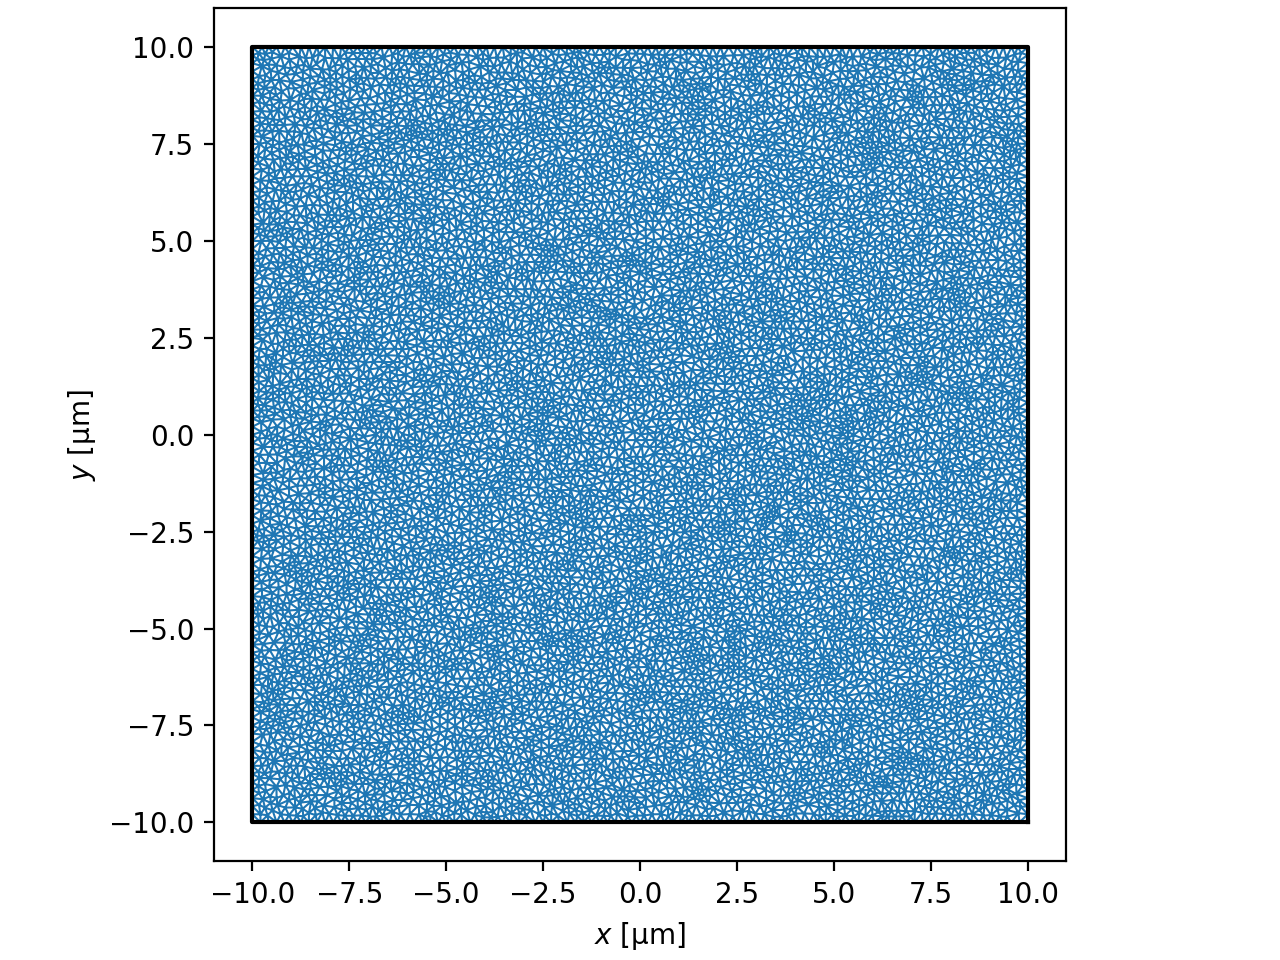

In [15]:
fig, ax = sample.plot_mesh()
_ = sample.plot_polygons(ax=ax, color="k")

<IPython.core.display.Javascript object>


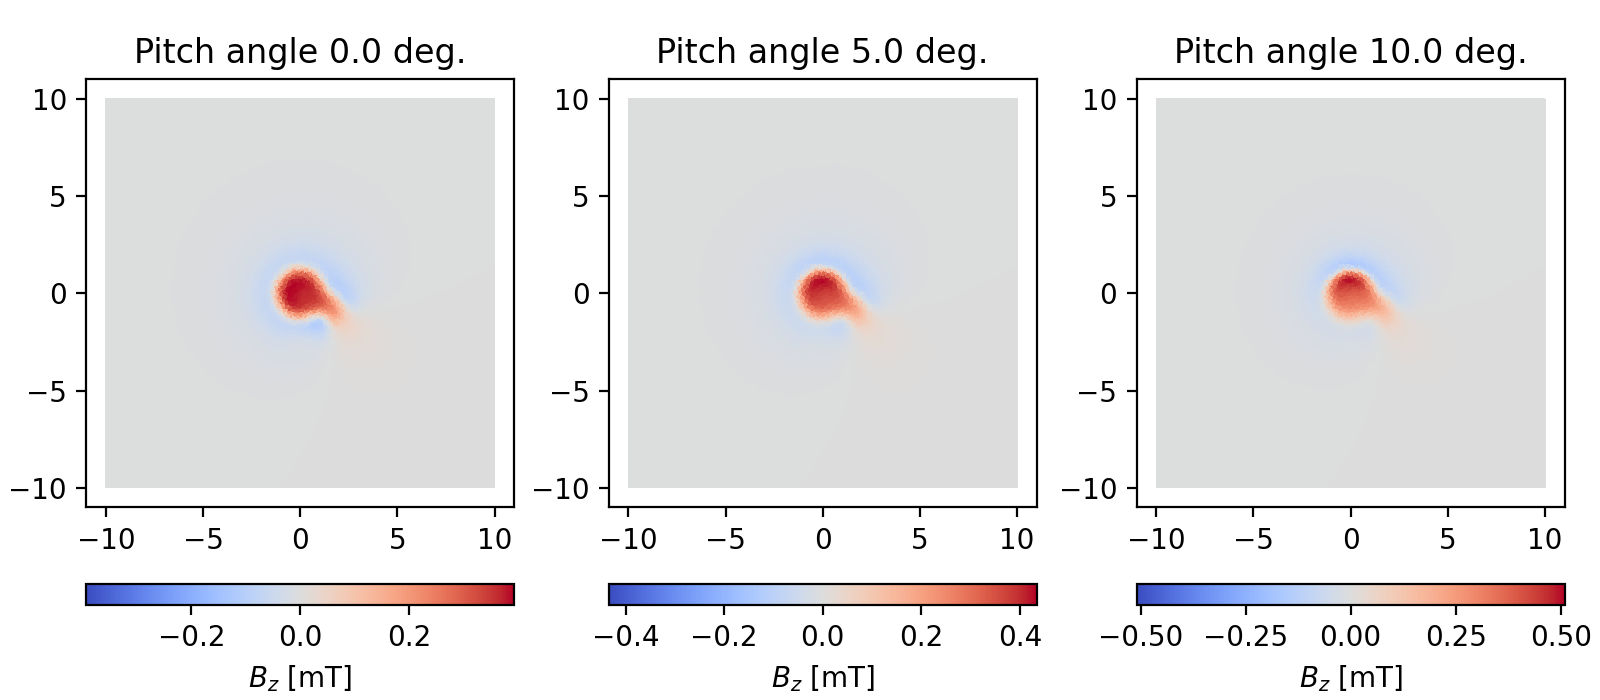

In [16]:
squid_height = 1

fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), layout="constrained")

for ax, pitch_angle in zip(axes, [0, 5, 10]):
    field_from_squid = susceptometry.field_from_solution(
        sample_xs,
        sample_ys,
        sample_zs,
        solution=fc_solution,
        dr=(0, 0, -squid_height),
        pitch=-pitch_angle,
        units="mT",
    )

    vmax = np.max(np.abs(field_from_squid))

    ax.set_aspect("equal")
    im = ax.tripcolor(
        sample_xs,
        sample_ys,
        field_from_squid,
        triangles=sample_tris,
        cmap="coolwarm",
        vmin=-vmax,
        vmax=+vmax,
    )
    cbar = fig.colorbar(im, ax=ax, location="bottom")
    cbar.set_label("$B_z$ [mT]")
    ax.set_title(f"Pitch angle {pitch_angle:.1f} deg.")

In [17]:
squid_model = sc.factorize_model(device=squid, current_units="mA")

squid_height = 1.0

susc_signal = susceptometry.get_susceptibility(
    sample,
    fc_solution,
    squid_position=(0, 0, squid_height),
    squid_model=squid_model,
    pitch=0,
)
print(f"Susceptibility: {susc_signal:.3f} Phi_0 / A")

Susceptibility: -5.641 Phi_0 / A


In [18]:
squid_height = 1.0
pitch_angles = np.linspace(0, 10, 26)

susc_signals = []

for angle in tqdm(pitch_angles):
    susc_signal = susceptometry.get_susceptibility(
        sample,
        fc_solution,
        squid_position=(0, 0, squid_height),
        squid_model=squid_model,
        pitch=angle,
    )
    susc_signals.append(susc_signal)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [02:25<00:00,  5.62s/it]


<IPython.core.display.Javascript object>


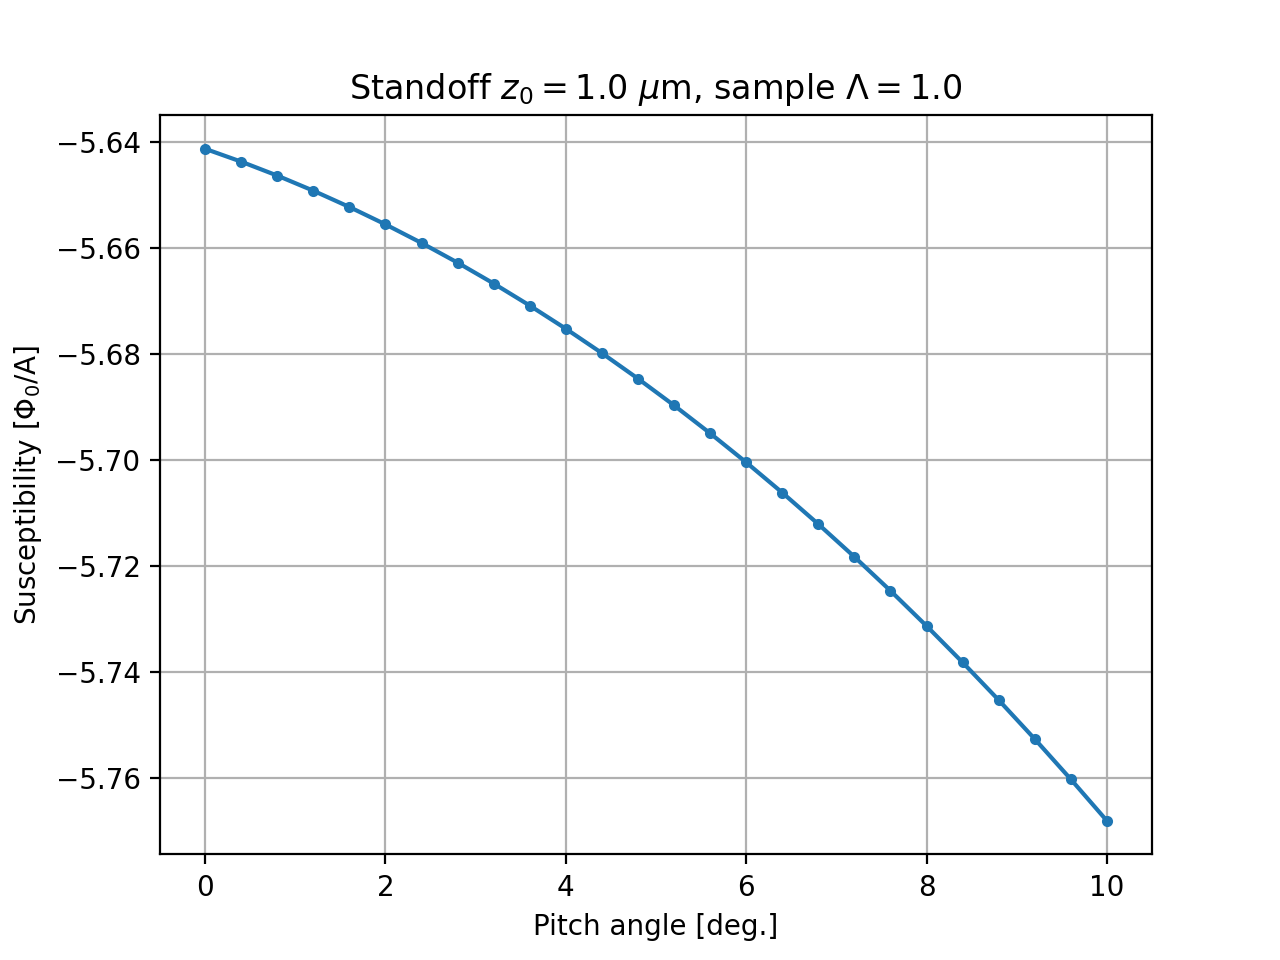

Text(0.5, 1.0, 'Standoff $z_0=$1.0 $\\mu$m, sample $\\Lambda=$1.0')

In [19]:
fig, ax = plt.subplots()
ax.grid(True)
ax.plot(pitch_angles, susc_signals, ".-")
ax.set_xlabel("Pitch angle [deg.]")
ax.set_ylabel("Susceptibility [$\\Phi_0$/A]")
ax.set_title(f"Standoff $z_0=${squid_height:.1f} $\\mu$m, sample $\\Lambda=${sample_Lambda}")